# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

see link to [forcing description](../configs/itbalt/readme.ipynb)

Diagnostics to store:

- surface: 
    - time and x averaged KE(y)
    - time and x averaged relative enstrophy (y)
    - time averaged horizontal wavenumber spectra

- with depth information:
    - time and x averaged KE(z, y)
    - time and x averaged relative enstrophy (z, y)

- time series of x averaged modal projection amplitudes

---

## important parameters and diagnostics to be implemented

- Rossby radius of deformation
- Rhines lengthscale: $ L_\beta = \sqrt{\langle \zeta^2 \rangle} / \beta $ or $\langle (u^2+v^2) \rangle^{1/4} / \beta$
- Bottom drag time scale
- Forcing lengthscale 

- total energy, enstrophy, potential enstrophy
- kinetic energy spectra
- modal decomposition
- centroid wavenumber (function of time, surface, vs per mode)
- relative vorticity kurtosis : $ \langle \zeta^4 \rangle / \langle \zeta^2 \rangle^2 $

- movies of: relative vorticity (surface, modally projected)


things to vary: forcing strength, beta, central latitude (f=0?) 

## useful references

McWilliams, J. C. The emergence of isolated coherent vortices in turbulent flow. Journal of Fluid Mechanics 146 (1984), 21–43.

McWilliams, J. C. Statistical properties of decaying geostrophic turbulence. Journal of Fluid Mechanics 198 (1989), 199–230.

Smith, K. S., and Vallis, G. K. The Scales and Equilibration of Midocean Eddies: Freely Evolving Flow. J. Phys. Oceanogr. 31 (2001), 554–571.

In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.vmodes as vmd
import crocosi.plot as cplt

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.27:53276 Dashboard: http://10.148.0.27:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [3]:
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/fsturb/'

run = 'fsturb_m0_4km_0a1000j/'
#run = 'fsturb_m1_4km_0a1000j/'
#run = 'fsturb_m0_a1m2_4km_0a1000j/'
#m, a = 1, '1m2'
#m, a = 0, '5m2'
#run = 'fsturb_m{}_a'.format(m)+a+'_4km_0a1000j/'

r = pp.Run(root_path+run, open_nc=['surf', 'his'], 
           grid_periodicity=True, 
           verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})
r['his'] = r['his'].rename({'time_counter': 'time'})
pout = r.params_output

Analysing directory /home/c11-data/Test_aponte/fsturb/fsturb_m0_4km_0a1000j/
Found 10 segments
Found 10 grid files
Found 50 his files
Found 20 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'his', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


---

## utils

In [4]:
def plot_Fy(p, ax=None, scale=1, ls='--', color='k', **kwargs):
    #p = r.params_output
    ymid = p['fst_ymid']*scale
    ywid = p['fst_ywid']*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

---

## bulk statistics

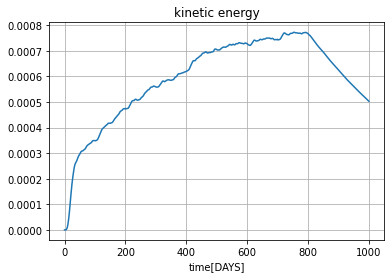

In [5]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()

In [12]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

#if store:
#r.store_diagnostic('surface', ds_mean, overwrite=True)
#
#ds_mean = r.load_diagnostic('surface')

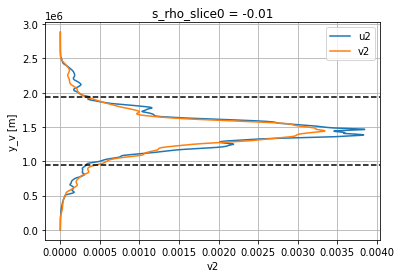

In [10]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()
plot_Fy(pout)

In [14]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

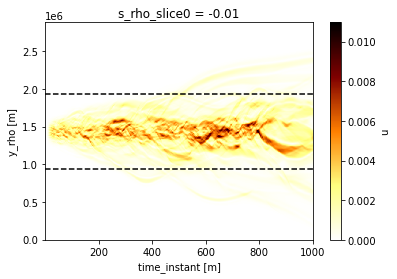

In [15]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape
plot_Fy(pout)

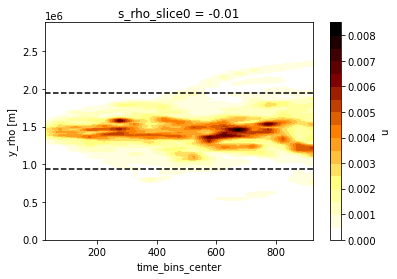

In [16]:
toplt = u2_meanx.groupby_bins('time',np.arange(0,1000,50)).mean('time').squeeze()
toplt.plot.contourf(x='time_bins', y='y_rho', levels=20, cmap='afmhot_r')
plot_Fy(pout)

--- 

## pictures

### sea level

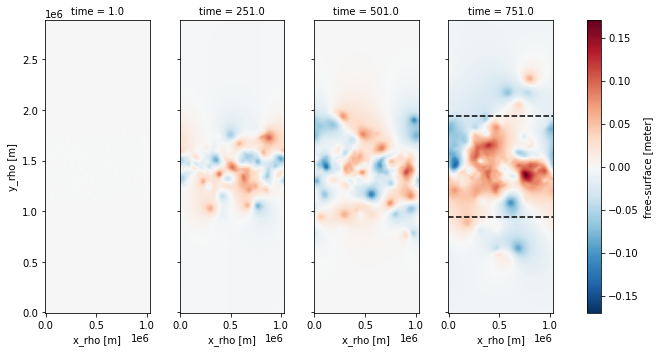

In [17]:
hdl = (r['surf']['ssh'].sel(time=slice(0,1000,250))
         .plot(x='x_rho', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

### surface zonal velocity

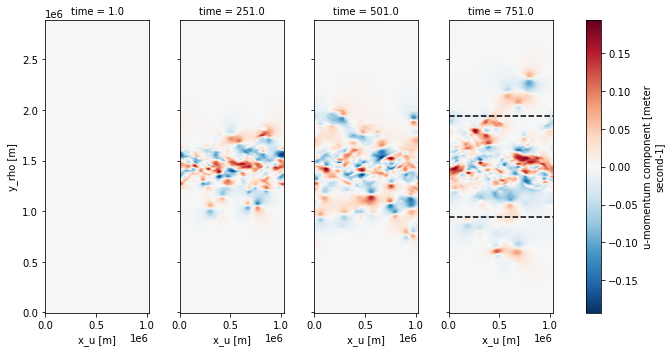

In [18]:
hdl = (r['surf']['u'].sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

### surface relative vorticity

In [19]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

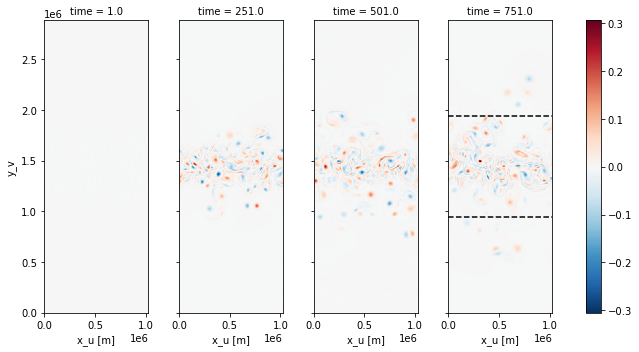

In [20]:
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
hdl = ((zeta/f_zeta).sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_v', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

### relative vorticity as a function of depth

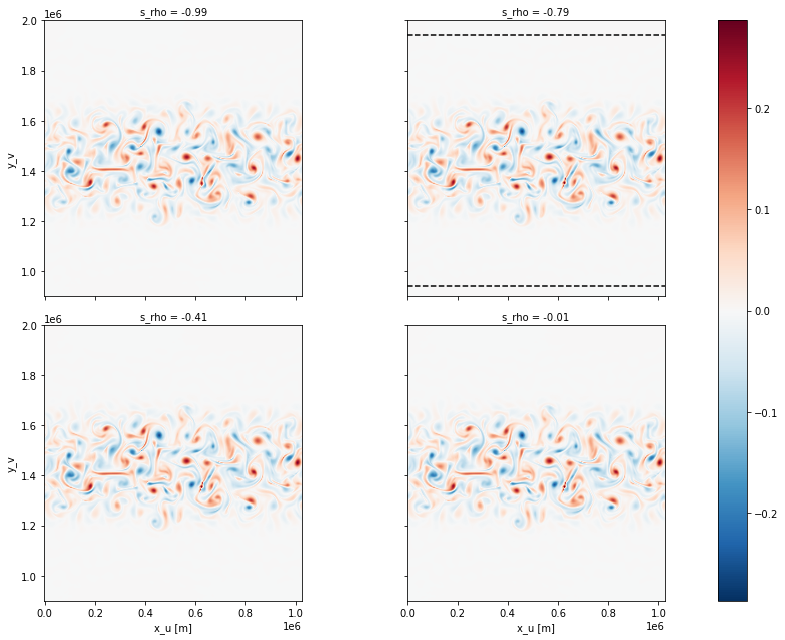

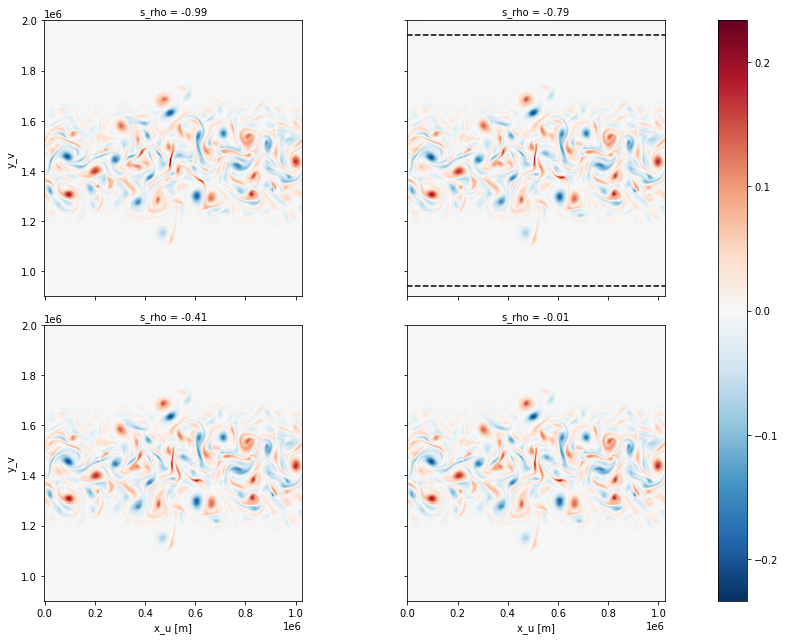

In [21]:
# from history files
u, v = r['his']['u_t_dirac'], r['his']['v_t_dirac']
zeta_his = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

for t in [50, 100]:

    f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
    hdl = ((zeta_his/f_zeta).sel(time=t, s_rho=[-1,-.8,-.4, 0.], method='nearest')
             .plot(x='x_u', y='y_v', col='s_rho', col_wrap=2, 
                   subplot_kws={'aspect':'equal'},
                   aspect=.5, figsize=(15,9),
                   ylim=(900*1e3, 2000*1e3))
    )
    plot_Fy(pout, ax=hdl.axes[0,-1])


<Figure size 432x288 with 0 Axes>

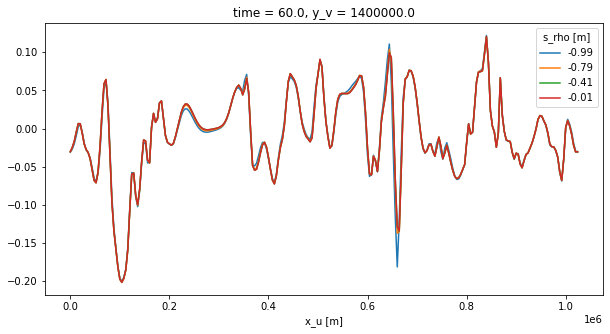

<Figure size 432x288 with 0 Axes>

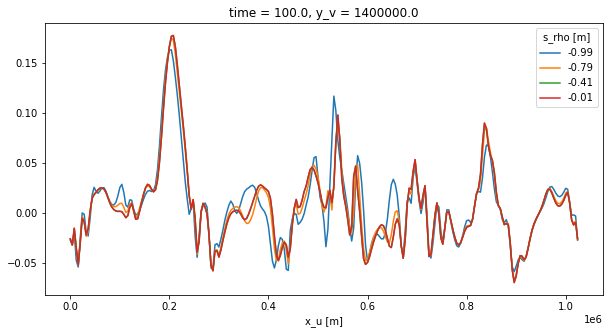

<Figure size 432x288 with 0 Axes>

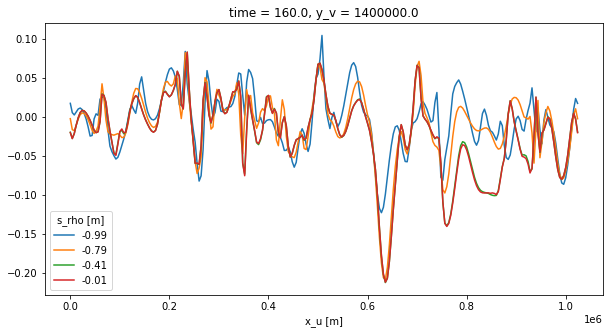

In [22]:
for t in [50, 100, 150]:

    f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
    plt.figure()
    hdl = ((zeta_his/f_zeta).sel(time=t, s_rho=[-1,-.8,-.4, 0.], y_v=1400e3, method='nearest')
             .plot(x='x_u', hue='s_rho', figsize=(10,5)) #col='s_rho', col_wrap=2
    )

---

## load vertical modes

In [6]:
# load vmodes from croco outputfiles

def open_vmode_file(f, r):
    ds = xr.open_dataset(f)
    for d in ds.dims:
        if ds[d].size==r.N:
            ds = ds.rename({d: 's_rho'})
            ds['s_rho'] = r['grid']['s_rho']
        elif ds[d].size==r.N+1:
            ds = ds.rename({d: 's_w'})
            ds['s_w'] = r['grid']['s_w']
        else:
            ds = ds.rename({d: 'mode'})
            ds['mode'] = np.arange(0,ds['mode'].size)
    ds = ds.rename(array=f.split('/')[-1].strip('vmodes_').replace('.nc',''))
    return ds

def load_vmodes_from_files(t):
    return xr.merge([open_vmode_file(f,r) 
                     for f in glob(r.dirname+'t{}/vmodes*.nc'.format(t))])
#ds_vm.set_coords('z_rho','z_w')

# first modal file
vmodes_croco = load_vmodes_from_files(1)
# should look whether mode evolve in time

# recompute vertical modes from output stratification
vmodes = vmd.Vmodes(r['xgrid'], 
                    vmodes_croco.zr, vmodes_croco.zw, 
                    vmodes_croco.N2, 
                    vmodes_croco.mode.size, 
                    persist=True)

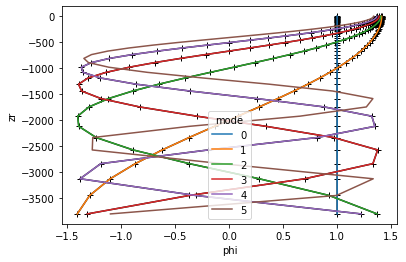

In [7]:
for i in range(5):
    plt.plot(vmodes_croco['phiuv'].isel(mode=i), 
             vmodes_croco.zr.values, marker='+', color='k')
vmodes['phi'].plot.line(y="zr", hue='mode')

## project and store

In [15]:
# a larger number of workers help here
#w = cluster.scale(jobs=10)
#cluster.close()

In [6]:
store = False
vmodes_name='vmodes'
    
if store:
    z_u = (r.get_z(zeta=r['his'].ssh_t_dirac, h=r['grid'].h, hgrid="u")
           .chunk({'x_u': 100, 'y_rho': 100}))
    z_v = (r.get_z(zeta=r['his'].ssh_t_dirac, h=r['grid'].h, hgrid="v")
           .chunk({'x_rho': 100, 'y_v': 100}))
    #
    u = r['his'].u_t_dirac.chunk({'x_u': 100, 'y_rho': 100})
    v = r['his'].v_t_dirac.chunk({'x_rho': 100, 'y_v': 100})
    #
    un = vmodes.project(u, "p", z=z_u).rename('un')
    vn = vmodes.project(v, "p", z=z_v).rename('vn')
    #
    ds = xr.merge([un, vn])
    r.store_vmodes(vmodes_name, vmodes, projections=ds)

In [7]:
# load from file
vmodes, ds = r.load_vmodes(vmodes_name, persist=True)

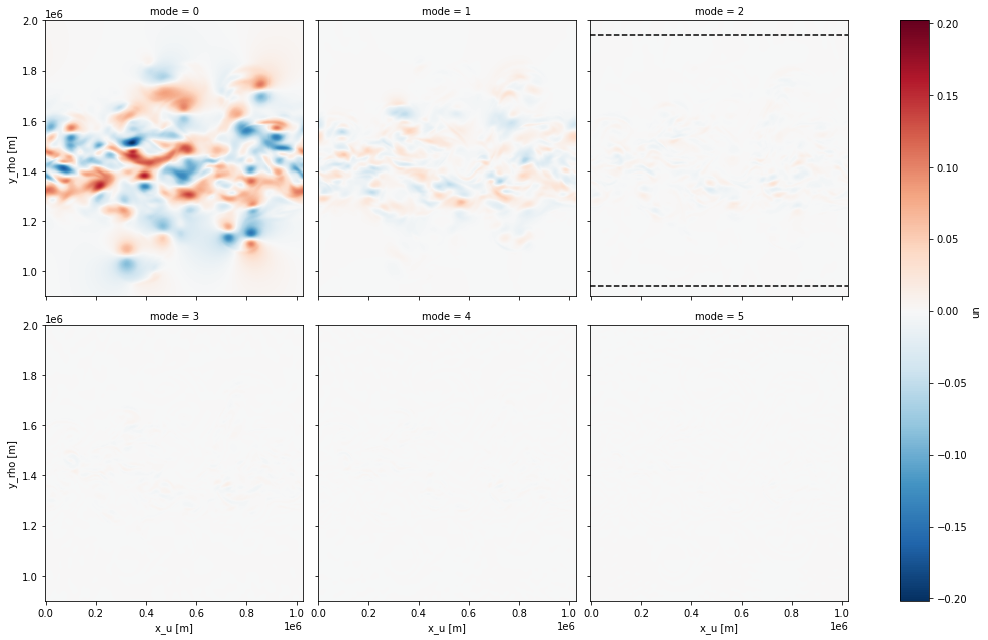

In [13]:
#ds['un'].isel(time=10).plot(col='mode', col_wrap=3)
hdl = (ds['un']
       .isel(time=10)
       .plot(x='x_u', y='y_rho', col='mode', col_wrap=3, 
             subplot_kws={'aspect':'equal'},
             aspect=.5, figsize=(15,9),
             ylim=(900*1e3, 2000*1e3))
      )
plot_Fy(pout, ax=hdl.axes[0,-1])

In [26]:
# compute spatially average KE
KEn = (.5*(r.x2rho(ds['un']**2)+r.x2rho(ds['vn']**2))
       .mean(dim=['x_rho','y_rho'])
       .persist()
      )

Text(0.5, 1.0, 'kinetic energy')

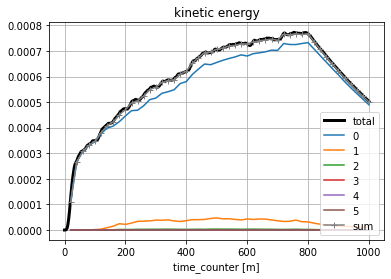

In [54]:
ax = r.stats['KINETIC_ENRG'].plot(lw=3., color='k')
hdl = KEn.plot.line(ax=ax, x='time')
KEn.sum('mode').plot.line(ax=ax, ls='-', marker='+', x='time', color='0.5')
ax.grid()
ax.legend(['total']+[int(i) for i in KEn.mode]+['sum'])
ax.set_title('kinetic energy')

---

## vertical slices

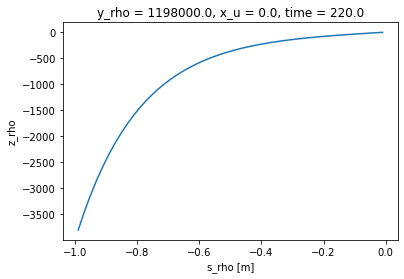

In [27]:
z_u = r.get_z(zeta=r['his'].ssh_t_dirac, hgrid='u')
ds = r['his'].assign_coords(z_u = z_u)
z_u.isel(x_u=0, y_rho=300, time=10).plot()

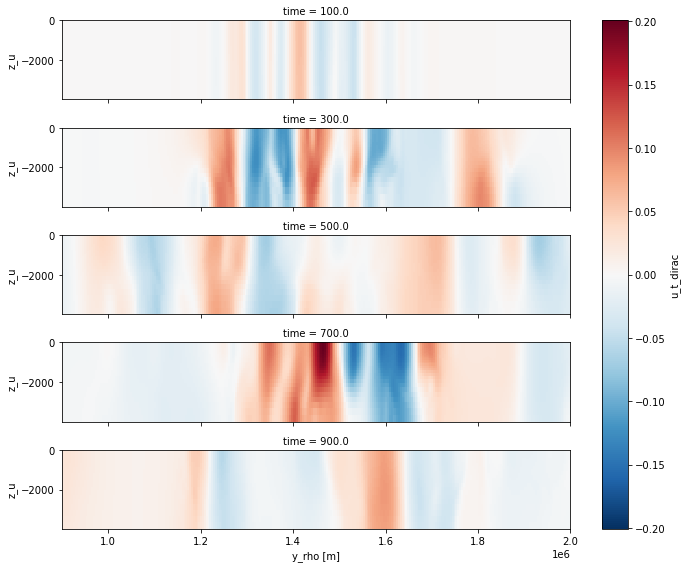

In [28]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=np.arange(100,1000,200), method='nearest')
 .plot(x='y_rho', y='z_u', 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col='time', col_wrap=1)
)

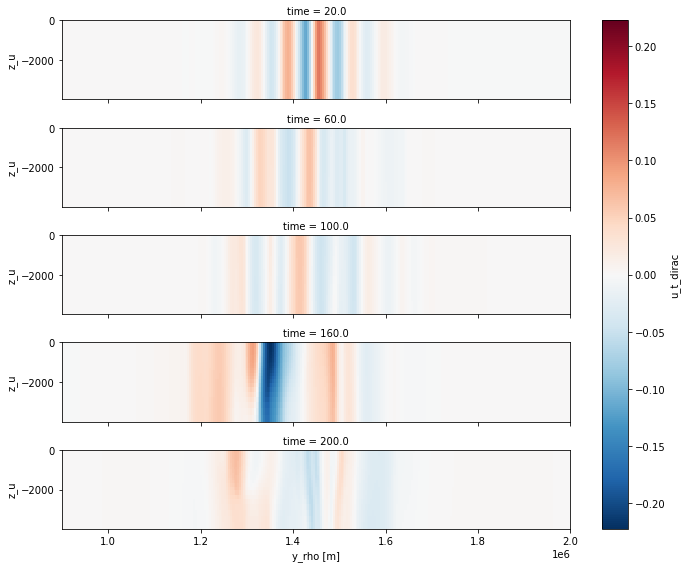

In [29]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=np.arange(0,250,50), method='nearest')
 .plot(x='y_rho', y='z_u', 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col='time', col_wrap=1)
)

In [30]:
ds.u_t_dirac.time.values

array([  20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.,
        200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,  360.,
        380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,  540.,
        560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,  720.,
        740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,  900.,
        920.,  940.,  960.,  980., 1000.])

In [31]:
lds = (ds.u_t_dirac
       .isel(x_u=0)
       .sel(y_rho=1400e3, time=range(20,100,20), method='nearest')
      ).persist()

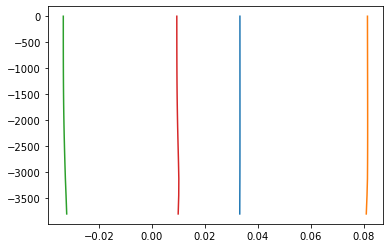

In [32]:
for t in lds.time.values:
    plt.plot(lds.sel(time=t), lds.sel(time=t).z_u)

ValueError: x and y must have same first dimension, but have shapes (50, 9) and (9, 50)

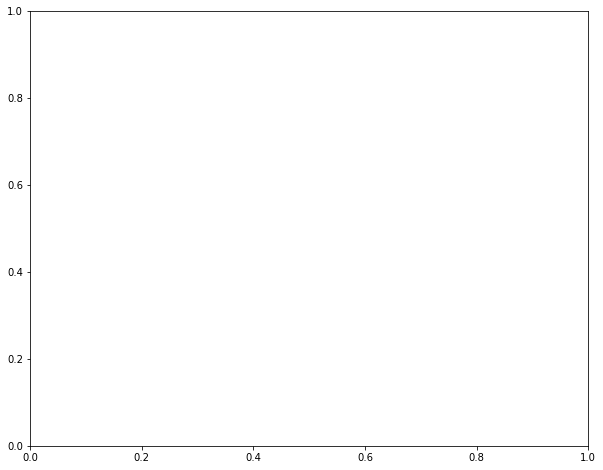

In [73]:
(ds.u_t_dirac
 .isel(x_u=0).sel(y_rho=1400e3, time=np.arange(100,1000,100), method='nearest')
 .plot.line(y='z_u', hue='time', figsize=(10,8))
)
# need to do a 

---

## wavenumber spectra with xrft

In [33]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [34]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()
ekehat

<xarray.DataArray (freq_y_rho: 722, freq_x_rho: 258)>
array([[3.33139261e-08, 1.59443968e-07, 5.63628534e-07, ...,
        1.22519288e-06, 5.63628534e-07, 1.59443968e-07],
       [4.81458565e-08, 1.78139284e-07, 5.83713409e-07, ...,
        1.25185874e-06, 5.73226731e-07, 1.70746497e-07],
       [9.51384840e-08, 2.27350009e-07, 6.29058769e-07, ...,
        1.32145360e-06, 6.16324078e-07, 2.13900723e-07],
       ...,
       [1.79234814e-07, 2.92349864e-07, 6.97792811e-07, ...,
        1.37542097e-06, 6.96594439e-07, 3.09666423e-07],
       [9.51384840e-08, 2.13900723e-07, 6.16324078e-07, ...,
        1.29314884e-06, 6.29058769e-07, 2.27350009e-07],
       [4.81458565e-08, 1.70746497e-07, 5.73226731e-07, ...,
        1.24029971e-06, 5.83713409e-07, 1.78139284e-07]])
Coordinates:
  * freq_y_rho          (freq_y_rho) float64 -0.000125 -0.0001247 ... 0.0001247
  * freq_x_rho          (freq_x_rho) float64 -0.000125 -0.000124 ... 0.000124
    freq_x_rho_spacing  float64 9.69e-07
    freq_y_rho_spacing  float64 3.463e-07

In [35]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [1/km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [1/km]')

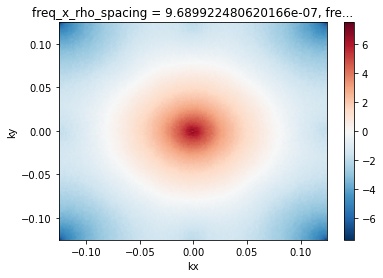

In [36]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [37]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

In [38]:
def add_slope(k_start=None, k_end=None, level_start=None, slope=None):
    if isinstance(slope, list):
        [add_slope(k_start, k_end, level_start, ls) for ls in slope]
    else:
        k = np.arange(k_start,k_end,(k_end-k_start)/3.)
        y = level_start*(k/k[0])**slope
        plt.plot(k, y, 'k')
        plt.text(k[-1], y[-1], ' {i}'.format(i=slope))

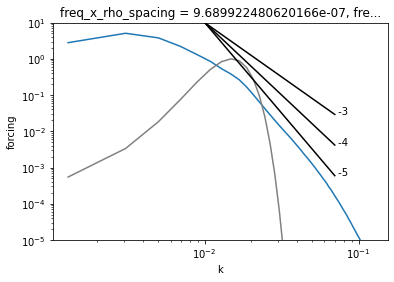

In [39]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

# get forcing wavenumbers
F_k = 1e3*r.params_output['fst_k']
F_dk = 1e3*r.params_output['fst_dk']
F = np.exp(-((ekehat_iso.k-F_k)/F_dk)**2).rename('forcing')

F.plot(x='k', xscale='log', yscale='log', 
                           ylim=(1e-5, 1e1), color='0.5')

add_slope(k_start=1e-2, k_end=1e-1, level_start=1e1, slope=[-3, -4, -5])

In [40]:
u = r['surf']['u'].sel(time=slice(50,1000,100))
v = r['surf']['v'].sel(time=slice(50,1000,100))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', 
                            window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', 
                            window=True).compute()
ekehat = .5*(uhat2 + vhat2)

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

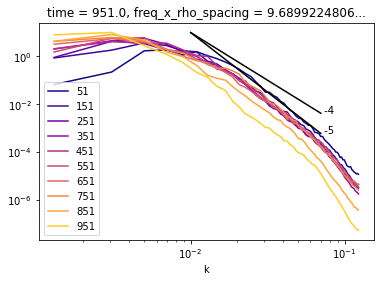

In [41]:
#hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')
#
colors = get_cmap_colors(ekehat_iso.time.size)
for t, c in zip(ekehat_iso.time, colors):
    ekehat_iso.sel(time=t).plot(x='k', color=c,
                                xscale='log', yscale='log',
                                label='{t}'.format(t=int(t)))
plt.legend()
#add_slope(1e-2, 1e-1, 1e-2, [-4,-5])
add_slope(k_start=1e-2, k_end=1e-1, level_start=1e1, slope=[-4, -5])

---

## make movies

In [42]:
def plt_atom(da, ax, ax_kwargs, **plt_kwargs):
    #
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time)
    title = da.name+' day = %d'%(d)
    #h = (_da.time-d)*24
    #title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da.plot(x='x',y='y', ax=ax, **plt_kwargs)
    plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

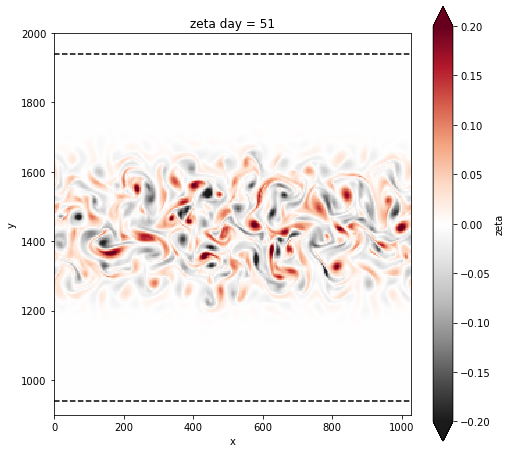

In [43]:
u, v = r['surf']['u'], r['surf']['v']

zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
da = (zeta/f_zeta).rename('zeta').isel(time=slice(0,None,1))
plt_kw = {'vmin': -.2, 'vmax': .2, 'cmap': 'RdGy_r', 
          'extend':'both'}
ax_kw = {'ylim': (900, 2000)}
movie_figure(da, i=50, test=True, figsize=(8,8), 
             ax_kwargs=ax_kw, **plt_kw)

In [46]:
movie_wrapper(da, client, figsize=(8,8),
            ax_kwargs=ax_kw, **plt_kw)

17 batches to be done
 batch 0-58
 batch 59-117
 batch 118-176
 batch 177-235
 batch 236-294
 batch 295-353
 batch 354-412
 batch 413-471
 batch 472-530
 batch 531-589
 batch 590-648
 batch 649-707
 batch 708-766
 batch 767-825
 batch 826-883
 batch 884-941
 batch 942-999


---

In [47]:
cluster.close()